In [1]:
import numpy as np
import matplotlib.pyplot as plt
from qutip import *
import os

# Matplotlib Einstellungen gemäß den LaTeX-Caption-Formatierungen
plt.rcParams.update({
    'text.usetex': True,              # Enable LaTeX for text rendering
    'text.latex.preamble': r'\usepackage{amsmath}',
    'font.family': 'serif',           # Use a serif font family
    'font.serif': 'Palatino',         # Set Palatino as the serif font
    'font.size': 20,                   # Font size for general text
    'axes.titlesize': 20,              # Font size for axis titles
    'axes.labelsize': 20,              # Font size for axis labels
    'xtick.labelsize': 20,             # Font size for x-axis tick labels
    'ytick.labelsize': 20,             # Font size for y-axis tick labels
    'legend.fontsize': 20,             # Font size for legends
    'figure.figsize': [8, 6],          # Size of the plot (width x height)
    'figure.autolayout': True,         # Automatic layout adjustment
    'savefig.format': 'svg',           # Default format for saving figures
    'figure.facecolor': 'none',        # Make the figure face color transparent
    'axes.facecolor': 'none',          # Make the axes face color transparent
    'savefig.transparent': True        # Save figures with transparent background
})

output_dir = r"C:\Users\leopo\OneDrive - UT Cloud\Uni\Semester_8\BA_mit_Git\BA_Latex\Figures_From_Python"
os.makedirs(output_dir, exist_ok=True)
name = 'ASYMM_TOPO'
########################################                 Define constants                   #############################################
fixed_lam = 1
fixed_gamma = 1
fixed_dist_ext = 0.1 * fixed_lam
k_a = 2 * np.pi / fixed_lam

In [45]:
######################################################### Functions #########################################################
def dipole_vector(phi):
    return np.array([np.cos(phi), np.sin(phi), 0])

def z_rotation(angle):
    return np.array([[np.cos(angle), -np.sin(angle), 0],
                     [np.sin(angle),  np.cos(angle), 0],
                     [0,              0,             1]])

def chain_positions(distance, N_atoms):
    Pos = np.zeros((N_atoms, 3))
    for i in range(N_atoms):
        Pos[i, 0] = i * distance
    return Pos

def topo_positions_only_1_inner(distance_in, N_atoms):
    if distance_in >= 2 * fixed_dist_ext:
        distance_in = 2 * fixed_dist_ext - 1e-5
    Pos = np.zeros((N_atoms, 3))
    N_chain = N_atoms // 3
    height = np.sqrt(fixed_dist_ext**2 - (distance_in / 2)**2)
    r_in = (2 * fixed_dist_ext * distance_in - distance_in**2)/(4*height)
    MB = np.sqrt(r_in**2 + (distance_in / 2)**2)
    angle = np.arccos(((r_in) / MB))
    A = np.array([height - r_in, 0, 0])
    B = np.array([r_in, distance_in/2, 0])
    C = np.array([r_in, -distance_in/2, 0])
    Chain = chain_positions(fixed_dist_ext, N_chain)
    Pos[:N_chain] = np.dot(Chain + A, z_rotation(np.pi).T)
    Pos = Pos[Pos[:, 0].argsort()]
    Pos[N_chain:2*N_chain] = np.dot(Chain, z_rotation(angle).T) + B
    Pos[2*N_chain:] = np.dot(Chain, z_rotation(-angle).T) + C
    return Pos

def Green_tensor(r_a, r_b):
    r_ab = r_b - r_a
    abs_r_ab = np.linalg.norm(r_ab)
    kappa = k_a * abs_r_ab
    return (np.exp(1j * kappa) / (4 * np.pi * kappa ** 2 * abs_r_ab)
                    * ((kappa ** 2 + 1j * kappa - 1) * np.eye(3)
                       + (- kappa ** 2 - 3 * 1j * kappa + 3)
                       * np.outer(r_ab, r_ab) / (abs_r_ab ** 2)))

def Gamma_matrix(dipoles, N_atoms):
    G_matrix = np.zeros((N_atoms, N_atoms), dtype=complex)
    for a in range(N_atoms):
        for b in range(N_atoms):
            r_a, r_b = pos[a], pos[b]
            G_matrix[a, b] = fixed_gamma
            if np.linalg.norm(r_b - r_a) > 1e-5:
                d_a, d_b = dipoles[a], dipoles[b]
                G_matrix[a, b] = np.imag((6 * np.pi * fixed_gamma / k_a * np.matmul(np.conj(d_a), np.matmul(Green_tensor(r_a, r_b), d_b.T))))
    return G_matrix

def V_matrix(dipoles, N_atoms):
    V_matrix = np.zeros((N_atoms, N_atoms), dtype=complex)
    for a in range(N_atoms):
        for b in range(N_atoms):
            r_a, r_b = pos[a], pos[b]
            V_matrix[a, b] = 0
            if np.linalg.norm(r_b - r_a) > 1e-5:
                d_a, d_b = dipoles[a], dipoles[b]
                V_matrix[a, b] = - np.real((3 * np.pi * fixed_gamma / k_a * np.matmul(np.conj(d_a), np.matmul(Green_tensor(r_a, r_b), d_b.T))))
    return V_matrix

def H_eff(dipoles):
    G = Gamma_matrix(dipoles, N_atoms)
    V = V_matrix(dipoles, N_atoms)
    # Generate connections based on the updated rules
    return Qobj(V) - 1j / 2 * Qobj(G)

def survival_probabilities(times, dipoles, Psi_0, N_atoms):
    H = H_eff(dipoles)
    coeffs_sq_mods  = np.zeros((len(times), N_atoms))
    P_surs  = np.zeros(len(times))
    for t_idx, t in enumerate(times):
        U = (-1j * H * t).expm()
        Psi_t = (U * Psi_0).full().flatten()
        Probs = np.abs(Psi_t)**2
        coeffs_sq_mods[t_idx, :] = Probs
        P_surs[t_idx] = Probs.sum()
    return coeffs_sq_mods, P_surs

def k_wave_packet(N_atoms):
    coefficients = np.exp(- (k_values - k_s) ** 2 / (4 * sigma_k ** 2))
    coefficients = coefficients / np.linalg.norm(coefficients)
    wave_packet_k = np.zeros(N_atoms, dtype=complex)
    
    for k, a_k in enumerate(coefficients):
        wave_packet_k += a_k * FT[:, k]

    wave_packet_k = wave_packet_k / np.linalg.norm(wave_packet_k)

    return wave_packet_k, coefficients

def real_space_wave_packet(N_atoms):
    coefficients = np.exp(- (k_values - k_s) ** 2 / (4 * sigma_k ** 2))

    # Do a phase shift to move the wavepacket in real space
    phase_shift = np.exp(1j * np.linspace(0, 2 * np.pi, N_atoms) * c * N_atoms)
    coefficients = coefficients * phase_shift

    wave_packet_real = np.zeros(N_atoms, dtype=complex)
    for alpha in range(N_atoms):
        a_alpha = 0
        for k, a_k in enumerate(coefficients):
            a_alpha += a_k * np.dot(np.eye(1, N_atoms, alpha, dtype=int).flatten(), FT[:,k])
        wave_packet_real[alpha] = a_alpha
    wave_packet_real = wave_packet_real / np.linalg.norm(wave_packet_real)
            
    return wave_packet_real

#
# PLOT THE Matrices in REAL and k space
#
def PLOT_REAL_and_K_MATRICES():
    plt.figure()
    im = plt.imshow(np.real(V), cmap='coolwarm', aspect='auto')
    max_value = np.max(np.real(V))
    min_value = np.min(np.real(V))
    
    cbar = plt.colorbar(im, label=r'$ V_{\alpha \beta} $')
    cbar.set_ticks([min_value, 0, max_value])
    cbar.set_ticklabels([f'{np.real(min_value):.1f}', '0', f'{np.real(max_value):.0f}'])
    
    plt.xlabel(r'$ \alpha $')
    plt.ylabel(r'$ \beta $')
    
    plt.xticks([0, N_atoms // 3, 2 * N_atoms // 3, N_atoms - 1])
    plt.yticks([0, N_atoms // 3, 2 * N_atoms // 3, N_atoms - 1])
    plt.gca().set_xticklabels([r'1', f'{N_atoms//3}', f'{2*N_atoms//3}', f'{N_atoms}'])
    plt.gca().set_yticklabels([r'1', f'{N_atoms//3}', f'{2*N_atoms//3}', f'{N_atoms}'])
    
    # Save the figure
    figure_name = name + f"_V_real_space_N={N_atoms}_angle={optimal_angle:.2f}_d_ext={fixed_dist_ext:.4f}_d_in={optimal_distance_in:.4f}.svg"
    if save_figs:
        plt.savefig(os.path.join(output_dir, figure_name))

    plt.show()
    
    plt.figure()
    im = plt.imshow(np.real(almost_D_V), cmap='coolwarm', aspect='auto')
    max_value = np.max(np.real(almost_D_V))
    min_value = np.min(np.real(almost_D_V))
    
    cbar = plt.colorbar(im, label=r'$ V_{k k^\prime} $')
    cbar.set_ticks([min_value, 0, max_value])
    cbar.set_ticklabels([f'{np.real(min_value):.1f}', '0', f'{np.real(max_value):.0f}'])
    
    plt.xticks([0, N_atoms // 3, 2 * N_atoms // 3, N_atoms - 1])
    plt.yticks([0, N_atoms // 3, 2 * N_atoms // 3, N_atoms - 1])
    plt.gca().set_xticklabels([r'1', f'{N_atoms//3}', f'{2*N_atoms//3}', f'{N_atoms}'])
    plt.gca().set_yticklabels([r'1', f'{N_atoms//3}', f'{2*N_atoms//3}', f'{N_atoms}'])
    
    plt.ylabel(r'$k$')
    plt.xlabel(r'$k^\prime$')
    
    # Save the figure
    figure_name = name + f"_V_momentum_space_N={N_atoms}_angle={optimal_angle:.2f}_d_ext={fixed_dist_ext:.4f}_d_in={optimal_distance_in:.4f}.svg"
    if save_figs:
        plt.savefig(os.path.join(output_dir, figure_name))

    plt.show()
    
    # Plot the G matrix (real space)
    plt.figure()
    im = plt.imshow(np.real(G), cmap='coolwarm', aspect='auto')
    max_value = np.max(np.real(G))
    min_value = np.min(np.real(G))
    
    cbar = plt.colorbar(im, label=r'$ G_{\alpha \beta} $')
    cbar.set_ticks([min_value, 0, max_value])
    cbar.set_ticklabels([f'{np.real(min_value):.1f}', '0', f'{np.real(max_value):.0f}'])
    
    plt.xlabel(r'$ \alpha $')
    plt.ylabel(r'$ \beta $')
    
    plt.xticks([0, N_atoms // 3, 2 * N_atoms // 3, N_atoms - 1])
    plt.yticks([0, N_atoms // 3, 2 * N_atoms // 3, N_atoms - 1])
    plt.gca().set_xticklabels([r'1', f'{N_atoms//3}', f'{2*N_atoms//3}', f'{N_atoms}'])
    plt.gca().set_yticklabels([r'1', f'{N_atoms//3}', f'{2*N_atoms//3}', f'{N_atoms}'])
    
    # Save the figure
    figure_name = name + f"_G_real_space_N={N_atoms}_angle={optimal_angle:.2f}_d_ext={fixed_dist_ext:.4f}_d_in={optimal_distance_in:.4f}.svg"
    if save_figs:
        plt.savefig(os.path.join(output_dir, figure_name))

    plt.show()
    
    # Compute almost_D_G matrix (momentum space for G matrix)
    plt.figure()
    im = plt.imshow(np.real(almost_D_G), cmap='coolwarm', aspect='auto')
    max_value = np.max(np.real(almost_D_G))
    min_value = np.min(np.real(almost_D_G))
    
    cbar = plt.colorbar(im, label=r'$ G_{k k^\prime} $')
    cbar.set_ticks([min_value, 0, max_value])
    cbar.set_ticklabels([f'{np.real(min_value):.1f}', '0', f'{np.real(max_value):.0f}'])
    
    plt.xticks([0, N_atoms // 3, 2 * N_atoms // 3, N_atoms - 1])
    plt.yticks([0, N_atoms // 3, 2 * N_atoms // 3, N_atoms - 1])
    plt.gca().set_xticklabels([r'1', f'{N_atoms//3}', f'{2*N_atoms//3}', f'{N_atoms}'])
    plt.gca().set_yticklabels([r'1', f'{N_atoms//3}', f'{2*N_atoms//3}', f'{N_atoms}'])
    
    plt.ylabel(r'$k$')
    plt.xlabel(r'$k^\prime$')
    
    # Save the figure
    figure_name = name + f"_G_momentum_space_N={N_atoms}_angle={optimal_angle:.2f}_d_ext={fixed_dist_ext:.4f}_d_in={optimal_distance_in:.4f}.svg"
    if save_figs:
        plt.savefig(os.path.join(output_dir, figure_name))

    plt.show()
    
#
# PLOT THE SPECTRUK in k space, WAVEPACKET IN k & REAL spcae 
#
def Plot_SPECTRUM_and_PSI_0():
    _, psik = k_wave_packet(N_atoms)
    norm_squared = np.abs(psik.flatten()) ** 2

    fig, ax1 = plt.subplots(figsize=(8, 4))
    ax1.scatter(k_values, eigenvalues_V, label=r'$ V_k $', color='#1f77b4', s=30, marker='o', alpha=0.8, edgecolor='#0177C9', linewidth=1.5) # Spectrum
    ax1.scatter(k_values, eigenvalues_G, label=r'$ \Gamma_k $', color='#ff7f0e', s=30, marker='o', alpha=0.8, edgecolor='#FF7F02', linewidth=1.5)  # Decay modes
    ax1.axvline(k_s, linestyle='--', alpha=0.25, color='black')                           # center of the wavepacket in P space

    # Determine the range of p values within p(k_s) ± 2*sigma_k
    from scipy.stats import linregress  # Import linear regression function
    k_range_indices = (k_values >= (k_s - 2 * sigma_k)) & (k_values <= (k_s + 2 * sigma_k))
    k_values_range = k_values[k_range_indices]
    V_values_range = eigenvalues_V[k_range_indices]
    # for plotting
    k_range_indices_plot = (k_values >= (k_s - 10 * sigma_k)) & (k_values <= (k_s + 10 * sigma_k))
    k_values_range_plot = k_values[k_range_indices_plot]
    # Fit a line through these V values
    slope, intercept, _, _, _ = linregress(k_values_range, V_values_range)
    print("The slope v_g is", slope)
    fitted_line_short = slope * k_values_range + intercept
    fitted_line = slope * k_values_range_plot + intercept
    ax1.plot(k_values_range_plot, fitted_line, color='red', linestyle='-', linewidth=2)
    ax1.plot(k_values_range[0], fitted_line_short[0], marker='|', color='red', markersize=10, markeredgewidth=2)
    ax1.plot(k_values_range[-1], fitted_line_short[-1], marker='|', color='red', markersize=10, markeredgewidth=2)

    ax2 = ax1.twinx()
    ax2.plot(k_values, norm_squared, color='#2ca02c', linewidth=2.5, label=r'$ |\psi_k(0)|^2 $')     # P Space Wave packet
    ax2.annotate(r'$k_\text{s}$', xy=(k_s, 1.2 * np.max(norm_squared)), ha='left', va='center')

    # legends
    ax1.set_xlabel(r'$k$')
    ax1.set_ylabel(r'$\text{E}/ \gamma$') # Eigenvalues
    ax2.set_ylabel(r'$|c_k|^2$')
    ax1.legend(loc='best')
    ax2.legend(loc='lower left')

    # lims, ticks
    y1_min = min(np.min(eigenvalues_V), np.min(eigenvalues_G))
    y1_max = max(np.max(eigenvalues_V), np.max(eigenvalues_G))
    ax1.set_ylim([round(y1_min, 0), round(y1_max, 0)])
    ax1.set_yticks([round(y1_min, 0), 0, round(y1_max, 0)])

    ax1.set_xlim(k_values[0], k_values[-1])
    xticks = [round(k_values[0], 1), 0, round(k_values[-1], 1)]
    sorted_by_closeness_to_one = sorted(range(len(eigenvalues_G)), key=lambda i: abs(eigenvalues_G[i] - 1))
    closest_two_indices = sorted_by_closeness_to_one[:2]  # Indices of the two eigenvalues closest to 1
    closest_two_k_values = [k_values[closest_two_indices[0]], k_values[closest_two_indices[1]]]
    xticks += [round(closest_two_k_values[0], 2), round(closest_two_k_values[1], 2)]  # Adding the two ticks, where G ~ 1
    xticks = sorted(xticks)
    ax1.set_xticklabels([r'$-\pi / d_{\text{ext}}$', 'b', 0, 'b', r'$\pi / d_{\text{ext}}$'])
    ax1.set_xticks(xticks)

    ax2.set_ylim(0, round(2 * np.max(norm_squared), 1))
    ax2.set_yticks([round(0, 0), round(2 * np.max(norm_squared), 1)])
    ax2.set_yticklabels([0, round(2 * np.max(norm_squared), 1)])
    
    # safe
    plt.tight_layout()
    figure_name = name + f"_P_SPACE_N={N_atoms}_angle={optimal_angle:.2f}_dist_ext=dist_in={fixed_dist_ext:.2f}_sigma_k={sigma_k/(np.pi / fixed_dist_ext):.3f}_k_s={k_s/(np.pi / fixed_dist_ext):.3f}.svg"    # Save The figure
    if save_figs:
        plt.savefig(os.path.join(output_dir, figure_name))

    plt.show()


    # NOW IN REAL SPACE
    psix = real_space_wave_packet(N_atoms)
    print(np.linalg.norm(psix))
    norm_squared = np.abs(psix.flatten()) ** 2
    alphas = np.arange(N_atoms)

    plt.figure(figsize=(4,2))
    plt.plot(alphas, norm_squared, color='#2ca02c', linewidth=2.5, label=r'$ |\psi_x(0)|^2 $')

    # lims, ticks
    plt.xlabel(r'$ \alpha $')
    plt.ylabel('Amp')
    plt.ylim(0, 2 * np.max(norm_squared)) # → When plotting the |_|^2
    plt.xlim(0, N_atoms) # → When plotting the |_|^2
    plt.yticks([round(0, 0), round(2 * np.max(norm_squared), 1)])
    plt.xticks([0, N_atoms//3, 2*N_atoms//3, N_atoms])

    # safe
    plt.tight_layout()
#    plt.title('REAL - SPACE')
    ax1.legend(loc='best')
    figure_name = name + f"_REAL_SPACE_N={N_atoms}_angle={optimal_angle:.2f}_dist_ext=dist_in={fixed_dist_ext:.2f}_sigma_k={sigma_k/(np.pi / fixed_dist_ext):.3f}_k_s={k_s/(np.pi / fixed_dist_ext):.3f}.svg"    # Save The figure
    if save_figs:
        plt.savefig(os.path.join(output_dir, figure_name))

    plt.show()


def PLOT_REAL_EVO():
    fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, gridspec_kw={'height_ratios': [3, 1]}, constrained_layout=True, figsize=(4, 4))

    im = ax1.imshow(y1.T, aspect='auto', origin='lower', cmap='coolwarm', extent=[0, t_max, 0, N_atoms])
    ax1.set_yticks([0, N_atoms//3, 2*N_atoms//3, N_atoms])
    ax1.set_yticklabels([1, N_atoms//3+1, 2*N_atoms//3+1, N_atoms])
    ax2.plot(times, y2, color='green', linewidth=2.5, label='collective')
    ax2.plot(times, np.exp(-times), 'r--', linewidth=2.5, label='1 atom')

    sum_l = np.sum(y1[:, 0:N_atoms//3+1], axis=1)
    sum_u = np.sum(y1[:, N_atoms//3+1:2*N_atoms//3+1], axis=1)

    ax2.plot(times, sum_l, label=r'$\text{left}$', color='#0177C9', linewidth=2)
    ax2.plot(times, sum_u, label=r'$\text{up}$', color='#FF7F02', linewidth=2)

    max_value = np.max(y1)
    cbar = fig.colorbar(im, ax=ax1, label=r'$ \vert c_{\alpha}(t)\vert ^2$')
    cbar.set_ticks([0, max_value])
    cbar.set_ticklabels([r'0', f'{max_value:.1f}'])

    ax2.set_ylim(0, 1.01)
    ax2.set_xticks([0, round(t_max/4), round(t_max/2), round(3* t_max/4), t_max])
    ax2.set_xticklabels(['0', f'{round(t_max/4)}', f'{round(t_max/2)}', f'{round(3*t_max/4)}', f'{round(t_max)}'])
    ax2.set_yticks([0, y2[-1], 1])
    ax2.set_yticklabels(['0', f'{y2[-1]:.2f}', '1'])
    ax1.set_ylabel(r'$\alpha$')
    ax2.set_xlabel(r'$\gamma t$')
    ax2.set_ylabel(r'$P_{\text{sur}}$')

    figure_name = name + f"_Evolution_N={N_atoms}_angle={optimal_angle:.2f}_dist_ext={fixed_dist_ext:.2f}_dist_in={optimal_distance_in:.2f}_sigma_k={sigma_k/(np.pi / fixed_dist_ext):.3f}_k_s={k_s/(np.pi / fixed_dist_ext):.3f}.svg"
    if save_figs:
        plt.savefig(os.path.join(output_dir, figure_name))

    plt.show()
'''    
    # Plot atoms with their dipole moments in the seperate plot
    plt.figure()
    plt.scatter(pos[:, 0], pos[:, 1], color='blue', s=50, label='Atoms')
    for i in range(N_atoms):
        plt.arrow(pos[i, 0], pos[i, 1], dipoles[i][0], dipoles[i][1])
    plt.title('Atom Positions and Dipole Moments')
    plt.xlabel('x / $\lambda$')
    plt.ylabel('y / $\lambda$')
    figure_name = name + f"Atom_Dipole_Pos_N={N_atoms}_angle={optimal_angle:.2f}_dist_ext={fixed_dist_ext:.2f}_dist_in={optimal_distance_in:.2f}_sigma_k={sigma_k/(np.pi / fixed_dist_ext):.3f}_k_s={k_s/(np.pi / fixed_dist_ext):.3f}.svg"
    if save_figs:
            plt.savefig(os.path.join(output_dir, figure_name))
    
    plt.axis('equal')
    plt.show()
    print(y2[-1])'''

'    \n    # Plot atoms with their dipole moments in the seperate plot\n    plt.figure()\n    plt.scatter(pos[:, 0], pos[:, 1], color=\'blue\', s=50, label=\'Atoms\')\n    for i in range(N_atoms):\n        plt.arrow(pos[i, 0], pos[i, 1], dipoles[i][0], dipoles[i][1])\n    plt.title(\'Atom Positions and Dipole Moments\')\n    plt.xlabel(\'x / $\\lambda$\')\n    plt.ylabel(\'y / $\\lambda$\')\n    figure_name = name + f"Atom_Dipole_Pos_N={N_atoms}_angle={optimal_angle:.2f}_dist_ext={fixed_dist_ext:.2f}_dist_in={optimal_distance_in:.2f}_sigma_k={sigma_k/(np.pi / fixed_dist_ext):.3f}_k_s={k_s/(np.pi / fixed_dist_ext):.3f}.svg"\n    if save_figs:\n            plt.savefig(os.path.join(output_dir, figure_name))\n    \n    plt.axis(\'equal\')\n    plt.show()\n    print(y2[-1])'

In [46]:
# THOSE determine the Shape of V_k, G_k 
N_atoms = 300
optimal_angle = 0.5531404633211924 # 0.502882171858528 # 
optimal_distance_in = 0.09252525252525252 # 0.1 # 
dipoles = [dipole_vector(optimal_angle) for _ in range(N_atoms)]
k_values = np.linspace(- np.pi/fixed_dist_ext, np.pi/fixed_dist_ext, N_atoms)
# Construct the Fourier Transform matrix
pos = topo_positions_only_1_inner(optimal_distance_in, N_atoms)

In [47]:
# Only initialize on the first Chain
N_atoms = N_atoms//3
dipoles = dipoles[:N_atoms]
pos = pos[:N_atoms]
    
k_values = np.linspace(- np.pi/fixed_dist_ext, np.pi/fixed_dist_ext, N_atoms)
FT = np.zeros((N_atoms, N_atoms), dtype=complex)
for alpha in range(N_atoms):
    FT[alpha, :] = np.exp(-1j * k_values * np.linalg.norm(pos[alpha]))
    FT[alpha, :] = FT[alpha, :]/ np.linalg.norm(FT[alpha, :])

# THOSE determine the Shape of V_k, G_k 
V = V_matrix(dipoles, N_atoms)
G = Gamma_matrix(dipoles, N_atoms)

almost_D_V = np.conjugate(FT.T) @ V @ FT
diagonal_entries_V = np.real(np.diag(almost_D_V))
almost_D_G = np.conjugate(FT.T) @ G @ FT
diagonal_entries_G = np.real(np.diag(almost_D_G))

eigenvalues_V = diagonal_entries_V
eigenvalues_G = diagonal_entries_G

In [48]:
save_figs = False

0.43434343434343436
The slope v_g is 0.8374042507322804


C:\Users\leopo\AppData\Local\Temp\ipykernel_14604\2746838409.py:268: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels([r'$-\pi / d_{\text{ext}}$', 'b', 0, 'b', r'$\pi / d_{\text{ext}}$'])


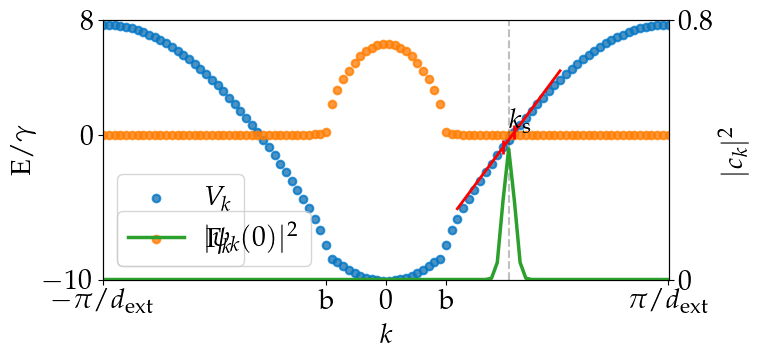

0.9999999999999998


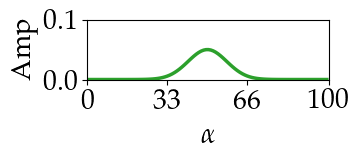

In [49]:
#PLOT_REAL_and_K_MATRICES()

# PLOT
k_s = k_values[-round(N_atoms/3.5)]
print(k_s / (np.pi / fixed_dist_ext))
sigma_k = 0.02 * np.pi / fixed_dist_ext
c = 1/2# center of psi_x: 0 <= c <= 1

Plot_SPECTRUM_and_PSI_0()

In [101]:
psi0 = real_space_wave_packet(N_atoms)
psi0 = Qobj(np.concatenate((psi0, np.zeros(2 * N_atoms))))

N_atoms = N_atoms * 3

In [102]:
dipoles = [dipole_vector(optimal_angle) for _ in range(N_atoms)]
k_values = np.linspace(- np.pi/fixed_dist_ext, np.pi/fixed_dist_ext, N_atoms)
pos = topo_positions_only_1_inner(optimal_distance_in, N_atoms)
t_max   = N_atoms // 4 # End Time
times = np.linspace(0, t_max, t_max * 1) * fixed_gamma

y1, y2 = survival_probabilities(times, dipoles, psi0, N_atoms)

C:\Users\Leopold\AppData\Local\Temp\ipykernel_4284\141164928.py:342: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig(os.path.join(output_dir, figure_name))
C:\Users\Leopold\AppData\Local\Temp\ipykernel_4284\141164928.py:342: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.savefig(os.path.join(output_dir, figure_name))
C:\Users\Leopold\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


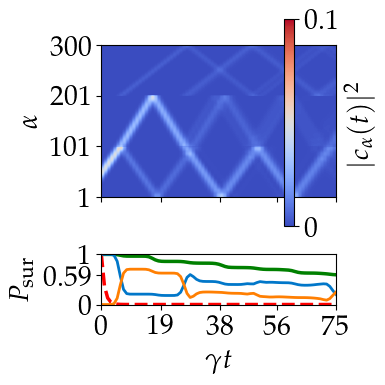

In [103]:
PLOT_REAL_EVO()

In [99]:
#
# Analyze Reflection and Transmission coefficients
#

# Define time and indices
N_chain = N_atoms // 3
# Find the index closest to the target time
T = 10
time_idx = np.argmin(np.abs(times - T))
# Extract the probabilities at the initial time (time = 0)
initial_probabilities = y1[0, :]

# Extract the probabilities at the target time
probabilities_at_target_time = y1[time_idx, :]

# Calculate the initial probability in the first N_chain states (should be ~1 initially)
initial_prob_first_third = initial_probabilities[:N_chain].sum()

# Reflection coefficient: Probability in the first N_chain states at target time
prob_first_third = probabilities_at_target_time[:N_chain].sum()

# Transmission coefficient: Probability in the second N_chain states at target time
prob_second_third = probabilities_at_target_time[N_chain:2 * N_chain].sum()

prob_third_third = probabilities_at_target_time[2 * N_chain:].sum()

# Calculate the reflection and transmission coefficients as ratios
reflection_coeff = prob_first_third / initial_prob_first_third
transmission_coeff = prob_second_third / initial_prob_first_third

print(f"Reflection Coefficient at time {T}: {(reflection_coeff * 100):3f}")
print(f"Transmission Coefficient at time {T}: {(transmission_coeff * 100):3f}")
print(f"leackage into lower arm at {T}: {(prob_third_third / initial_prob_first_third * 100):3f}")

Reflection Coefficient at time 10: 21.956416
Transmission Coefficient at time 10: 72.215814
leackage into lower arm at 10: 1.278827
